In [64]:
#Librerías básicas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

#Librerías para scrapear 
import requests
from bs4 import BeautifulSoup
from io import StringIO

#Librerías relacionadas con rutas
import os
import sys

#ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost
import lightgbm as lgb

# TABLA INICIAL

Gracias a los análisis llevados a cabo en el notebook [02_LimpiezaEDA.ipynb](../notebooks/02_LimpiezaEDA.ipynb), tenemos la siguiente tabla:

In [2]:
df = pd.read_csv("../data/processed/salaries_final_v2.csv")
df

,work_year,experience_level,job_title,salary_currency,salary_in_usd,remote_ratio,company_size,company_region,company_country,company_capital,...,company__Asia,company__Europe,company__Oceania,job_title_grouping,Business Intelligence & Analytics,Data Engineering & Infrastructure,Data Science & Machine Learning,Management & Leadership,Software Development & Engineering,Specialized Roles
0,2024,3,Associate,USD,113000,0,2,North America,Canada,Ottawa,...,0,0,0,Specialized Roles,0,0,0,0,0,1
1,2024,3,Associate,USD,75000,0,2,North America,Canada,Ottawa,...,0,0,0,Specialized Roles,0,0,0,0,0,1
2,2024,3,Research Scientist,USD,208000,0,2,North America,United States,"Washington, DC",...,0,0,0,Specialized Roles,0,0,0,0,0,1
3,2024,3,Research Scientist,USD,147000,0,2,North America,United States,"Washington, DC",...,0,0,0,Specialized Roles,0,0,0,0,0,1
4,2024,3,Machine Learning Engineer,USD,214500,0,2,North America,United States,"Washington, DC",...,0,0,0,Data Science & Machine Learning,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27619,2021,2,Data Engineer,EUR,28369,50,3,Southern Europe,Malta,Valletta,...,0,1,0,Data Engineering & Infrastructure,0,1,0,0,0,0
27620,2021,3,Data Specialist,USD,165000,100,3,North America,United States,"Washington, DC",...,0,0,0,Specialized Roles,0,0,0,0,0,1
27621,2021,2,Principal Data Scientist,USD,151000,100,3,North America,United States,"Washington, DC",...,0,0,0,Data Science & Machine Learning,0,0,1,0,0,0
27622,2020,1,Data Scientist,USD,105000,100,1,North America,United States,"Washington, DC",...,0,0,0,Data Science & Machine Learning,0,0,1,0,0,0


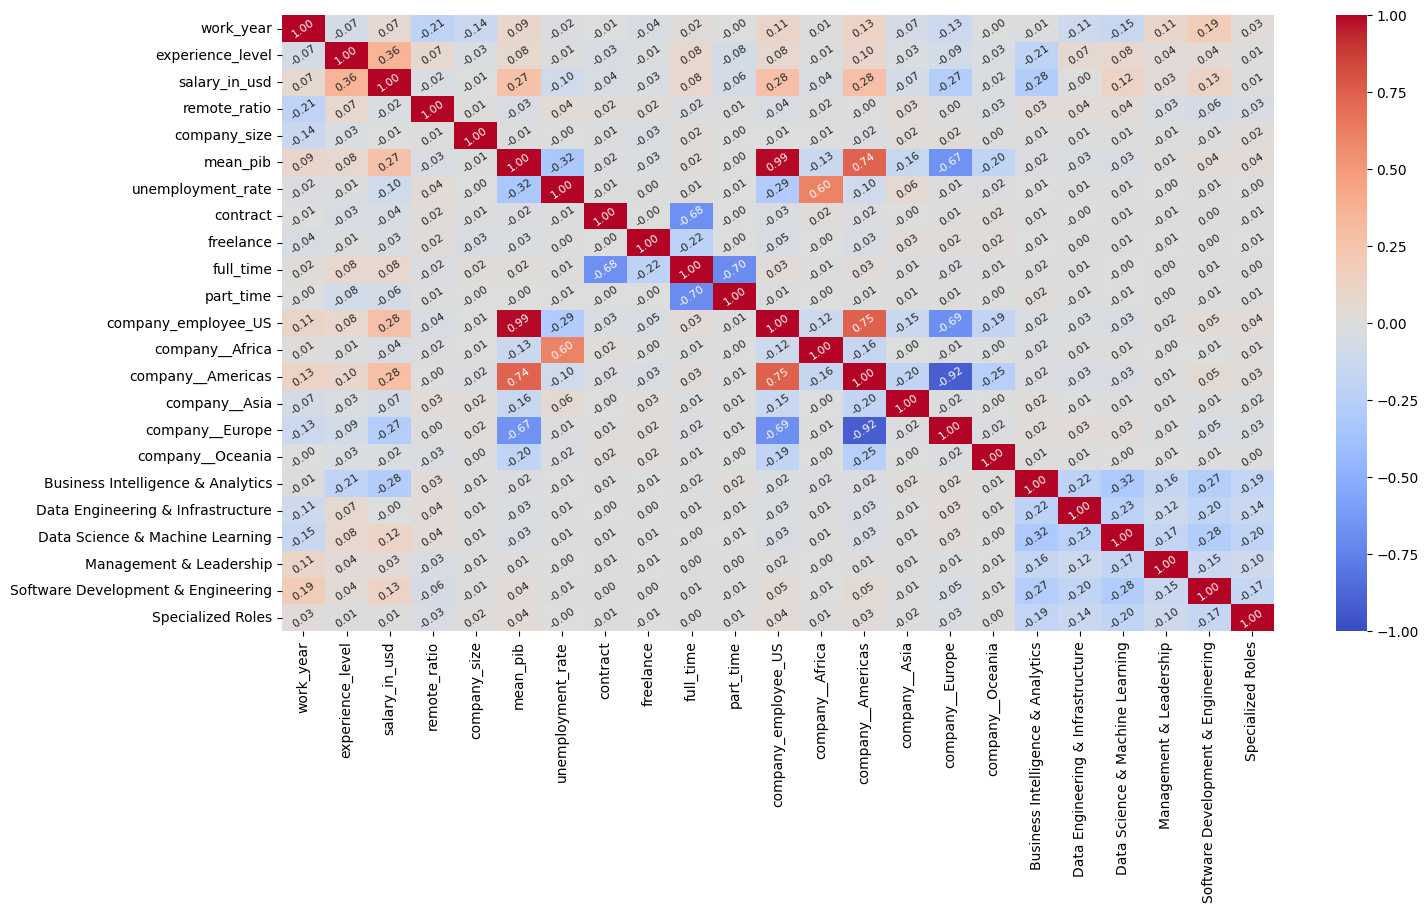

In [3]:
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, annot_kws={'size': 8, 'rotation': 35}, fmt='.2f', cmap="coolwarm"); 

# CREACIÓN DE LOS CONJUNTOS DE TRAIN Y TEST

Antes de escoger las variables predictoras que formarán parte de nuestro modelo, dividimos el dataset en dos conjuntos: Uno de entrenamiento y otro de test.

In [4]:
#Definimos los conjuntos de train/test
train_df, test_df = train_test_split(df, test_size=0.25, shuffle=True, random_state=42)

#Reseteamos los índices de los conjuntos recién definidos
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

#Los almacenamos en la carpeta que les corresponde
train_df.to_csv("../data/train/train.csv", index=False)
test_df.to_csv("../data/test/test.csv",  index=False)

In [5]:
len(train_df) + len(test_df) == len(df)

True

# VARIABLES PREDICTORAS

Si nos fijamos en el mapa de calor previo, vemos que hay muchas variables con gran correlación con el target y, adicionalmente, con gran correlación entre ellas. No obstante, vamos a usar todas ellas como predictoras en la definición de nuestro primer modelo, que será un **DECISION TREE REGRESSOR**, para el que posteriormente calcularemos su atributo *features_importance_* para elegir con cuáles nos quedaremos.

In [6]:
df.corr(numeric_only=True).columns

Index(['work_year', 'experience_level', 'salary_in_usd', 'remote_ratio',
       'company_size', 'mean_pib', 'unemployment_rate', 'contract',
       'freelance', 'full_time', 'part_time', 'company_employee_US',
       'company__Africa', 'company__Americas', 'company__Asia',
       'company__Europe', 'company__Oceania',
       'Business Intelligence & Analytics',
       'Data Engineering & Infrastructure', 'Data Science & Machine Learning',
       'Management & Leadership', 'Software Development & Engineering',
       'Specialized Roles'],
      dtype='object')

## MODELO 1 (Decision Tree Regressor)

In [ ]:
#Definimos el conjunto de variables predictoras y el target
X0_train = train_df[["experience_level", "mean_pib", "unemployment_rate", "company_employee_US", "company__Americas", "company__Europe", 'Business Intelligence & Analytics', 'Data Science & Machine Learning', 'Software Development & Engineering']]
y_train = train_df["salary_in_usd"]

X0_test = test_df[["experience_level", "mean_pib", "unemployment_rate", "company_employee_US", "company__Americas", "company__Europe", 'Business Intelligence & Analytics', 'Data Science & Machine Learning', 'Software Development & Engineering']]
y_test = test_df["salary_in_usd"]

In [8]:
#Definición del primer modelo
dtr = DecisionTreeRegressor()

params_dtr = {
    "max_depth": np.arange(2,8),
    "min_samples_leaf": [15,20,25],
    "criterion": ["absolute_error"]
}

dtr_gs = GridSearchCV(dtr, params_dtr, cv=5, scoring='neg_mean_absolute_error', verbose=2)

In [9]:
#No escalamos porque en los árboles de decisión no es necesario
dtr_gs.fit(X0_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END criterion=absolute_error, max_depth=2, min_samples_leaf=15; total time=   2.2s
[CV] END criterion=absolute_error, max_depth=2, min_samples_leaf=15; total time=   2.2s
[CV] END criterion=absolute_error, max_depth=2, min_samples_leaf=15; total time=   2.2s
[CV] END criterion=absolute_error, max_depth=2, min_samples_leaf=15; total time=   2.5s
[CV] END criterion=absolute_error, max_depth=2, min_samples_leaf=15; total time=   2.2s
[CV] END criterion=absolute_error, max_depth=2, min_samples_leaf=20; total time=   2.3s
[CV] END criterion=absolute_error, max_depth=2, min_samples_leaf=20; total time=   2.4s
[CV] END criterion=absolute_error, max_depth=2, min_samples_leaf=20; total time=   2.6s
[CV] END criterion=absolute_error, max_depth=2, min_samples_leaf=20; total time=   2.2s
[CV] END criterion=absolute_error, max_depth=2, min_samples_leaf=20; total time=   2.1s
[CV] END criterion=absolute_error, max_depth=2, min_samples

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['absolute_error'],
                         'max_depth': array([2, 3, 4, 5, 6, 7]),
                         'min_samples_leaf': [15, 20, 25]},
             scoring='neg_mean_absolute_error', verbose=2)

In [10]:
print(dtr_gs.best_score_)
print(dtr_gs.best_params_)
print(dtr_gs.best_estimator_)

-44181.861491052965
{'criterion': 'absolute_error', 'max_depth': 7, 'min_samples_leaf': 15}
DecisionTreeRegressor(criterion='absolute_error', max_depth=7,
                      min_samples_leaf=15)


In [11]:
#Entrenamos el modelo que hemos obtenido como el mejor del grid search previo
dtr_gs_final = dtr_gs.best_estimator_
dtr_gs_final.fit(X0_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=7,
                      min_samples_leaf=15)

In [12]:
#Predicción del modelo
y_pred_dtr_gs_final = dtr_gs_final.predict(X0_test) 

#Cálculo del r cuadrado para train y para test
print("R2 score train", dtr_gs_final.score(X0_train, y_train))
print("R2 score test", dtr_gs_final.score(X0_test, y_test))

R2 score train 0.24088061325968146
R2 score test 0.2645762150365014


In [16]:
#Calculamos el MAE para train y para test: 
print("MAE train", metrics.mean_absolute_error(y_train, dtr_gs_final.predict(X0_train)))
print("MAE test", metrics.mean_absolute_error(y_test, dtr_gs_final.predict(X0_test)))

MAE train 43851.00984651028
MAE test 42927.27577468868


- El $R^{2}$ del test se debe mejorar
- El mean absolute error debemos disminuirlo porque es un error bastante grande para nuestra target

A continuación, procedemos a calcular el atributo de *feature_importances* para volver a entrenar al modelo ahora sólo con las variables predictoras más relevantes para dicho modelo

In [17]:
dtr_gs_final.feature_importances_

array([0.39700087, 0.01061322, 0.03321377, 0.03451856, 0.25228092,
       0.02685501, 0.21980329, 0.0172684 , 0.00844597])

<Axes: >

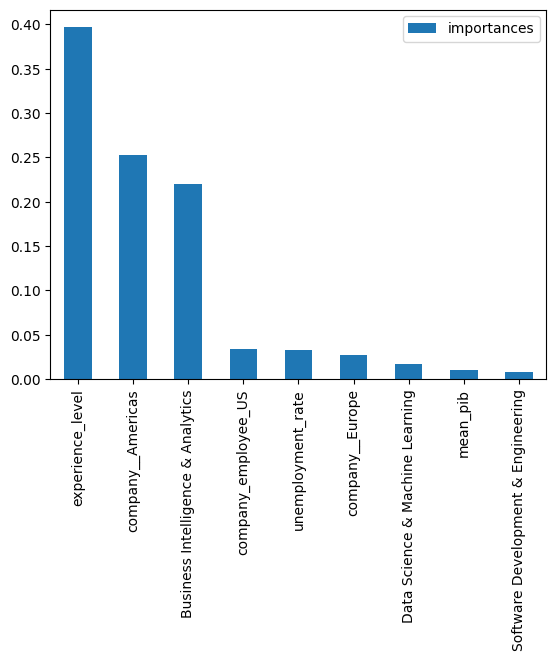

In [18]:
pd.DataFrame({'importances':dtr_gs_final.feature_importances_}, index=X0_train.columns).sort_values("importances",ascending=False).plot(kind='bar')

Entrenamos el modelo ahora sólo a partir de los campos que presentan mayor importancia, ayudándonos para ello del gráfico anterior:

In [22]:
#X1_train = train_df[["experience_level", "company__Americas", 'Business Intelligence & Analytics']] Este empeora con respecto a X0
X1_train = train_df[["experience_level", "company__Americas", 'Business Intelligence & Analytics', "unemployment_rate", "company_employee_US", "company__Europe"]]

#X1_test = test_df[["experience_level", "company__Americas", 'Business Intelligence & Analytics']]
X1_test = test_df[["experience_level", "company__Americas", 'Business Intelligence & Analytics', "unemployment_rate", "company_employee_US", "company__Europe"]]

In [23]:
#Entrenamos el modelo
dtr_gs_final.fit(X1_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=7,
                      min_samples_leaf=15)

In [24]:
#Cálculo del r cuadrado para train y para test
print("R2 score train", dtr_gs_final.score(X1_train, y_train))
print("R2 score test", dtr_gs_final.score(X1_test, y_test))


print("MAE train", metrics.mean_absolute_error(y_train, dtr_gs_final.predict(X1_train)))
print("MAE test", metrics.mean_absolute_error(y_test, dtr_gs_final.predict(X1_test)))

R2 score train 0.23301793010032346
R2 score test 0.25763054405391017
MAE train 44060.893232937546
MAE test 43132.542499275994


Las métricas siguen empeorando, probamos con otro modelo. Pero primero guardamos el modelo para el que mejor MAE hemos obtenido:

In [ ]:
#Lo volvemos a entrenar con el conjunto de variables predictoras que mejor nos ha funcionado
dtr_gs_final.fit(X0_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=7,
                      min_samples_leaf=15)

In [82]:
pickle.dump(dtr_gs_final, open("../models/trained_model_1.pkl", "wb"))

In [83]:
dtr_importado = pickle.load(open("../models/trained_model_1.pkl", "rb"))
dtr_importado.predict(X0_test)

array([160984.5, 114444. , 131500. , ..., 131500. , 163200. , 163200. ])

## MODELO 2 (SVR)

A diferencia de los árboles de decisión, el resto de modelos sí que vamos a escalarlos:

In [25]:
#StandardScaler
stand_scaler = StandardScaler()

#MinMaxScaler
minmax_scaler = MinMaxScaler()

In [26]:
#Escalamos con StandardScaler
X0_train_stand_scaler = stand_scaler.fit_transform(X0_train)
X0_test_stand_scaler = stand_scaler.transform(X0_test)

#Escalamos con MinMaxScaler
X0_train_minmax_scaler = minmax_scaler.fit_transform(X0_train)
X0_test_minmax_scaler = minmax_scaler.transform(X0_test)

Vamos a usar el Randomized Search pero vamos a hacerlo en dos partes diferentes: 

- Uno para un modelo con kernel = rbf
- Uno para un modelo con kernel = poly

*(Se ha intentado hacer en un único paso pero, debido al volumen de datos, el tiempo de ejecución era muy alto y no se ha llegado a obtener nada)*

In [27]:
#Definición del segundo modelo (SVR con kernel="rbf")
svr_rbf = SVR(kernel="rbf")

params_svr_rbf = {"C": [0.01, 0.1, 0.5, 1.0, 5.0, 15],
            "gamma": [0.001, 0.1, 1.0, 10.0], 
            "epsilon": [0.01, 0.1, 0.5, 1.0]
           }

svr_rbf_rs = RandomizedSearchCV(svr_rbf, params_svr_rbf, cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1, random_state=42, n_iter = 20)

In [28]:
#Entrenamos el modelo con el X0 escalado
svr_rbf_rs.fit(X0_train_stand_scaler, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=SVR(), n_iter=20, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 0.5, 1.0, 5.0, 15],
                                        'epsilon': [0.01, 0.1, 0.5, 1.0],
                                        'gamma': [0.001, 0.1, 1.0, 10.0]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [29]:
print(svr_rbf_rs.best_score_)
print(svr_rbf_rs.best_params_)
print(svr_rbf_rs.best_estimator_)

-49720.07761958065
{'gamma': 0.1, 'epsilon': 0.1, 'C': 15}
SVR(C=15, gamma=0.1)


In [30]:
#Entrenamos el modelo que hemos obtenido como el mejor del randomized search previo
svr_rbf_rs_final = svr_rbf_rs.best_estimator_
svr_rbf_rs_final.fit(X0_train_stand_scaler, y_train)

SVR(C=15, gamma=0.1)

In [31]:
#Cálculo del r cuadrado para train y para test
print("R2 score train", svr_rbf_rs_final.score(X0_train_stand_scaler, y_train))
print("R2 score test", svr_rbf_rs_final.score(X0_test_stand_scaler, y_test))

R2 score train 0.09379982350021987
R2 score test 0.10000625018399367


In [32]:
#Calculamos el MAE para train y para test: 
print("MAE train", metrics.mean_absolute_error(y_train, svr_rbf_rs_final.predict(X0_train_stand_scaler)))
print("MAE test", metrics.mean_absolute_error(y_test, svr_rbf_rs_final.predict(X0_test_stand_scaler)))

MAE train 48952.90373843769
MAE test 48510.45491421967


Probamos con otras variables predictoras:

In [33]:
X2_train = train_df[["experience_level", "unemployment_rate", "company_employee_US", 'Business Intelligence & Analytics', 'Data Science & Machine Learning', 'Software Development & Engineering']]
X2_test = test_df[["experience_level", "unemployment_rate", "company_employee_US", 'Business Intelligence & Analytics', 'Data Science & Machine Learning', 'Software Development & Engineering']]

X2_train_stand_scaler = stand_scaler.fit_transform(X2_train)
X2_test_stand_scaler = stand_scaler.transform(X2_test)

In [34]:
#Entrenamos el modelo 
svr_rbf_rs_final.fit(X2_train_stand_scaler, y_train)

#Cálculo del r cuadrado para train y para test
print("R2 score train", svr_rbf_rs_final.score(X2_train_stand_scaler, y_train))
print("R2 score test", svr_rbf_rs_final.score(X2_test_stand_scaler, y_test))
#Calculamos el MAE para train y para test: 
print("MAE train", metrics.mean_absolute_error(y_train, svr_rbf_rs_final.predict(X2_train_stand_scaler)))
print("MAE test", metrics.mean_absolute_error(y_test, svr_rbf_rs_final.predict(X2_test_stand_scaler)))

R2 score train 0.091880757712959
R2 score test 0.09713381646021624
MAE train 49011.792832603336
MAE test 48588.353107997464


In [35]:
#Entrenamos el modelo 
svr_rbf_rs_final.fit(X0_train_minmax_scaler, y_train)

#Cálculo del r cuadrado para train y para test
print("R2 score train", svr_rbf_rs_final.score(X0_train_minmax_scaler, y_train))
print("R2 score test", svr_rbf_rs_final.score(X0_test_minmax_scaler, y_test))
#Calculamos el MAE para train y para test: 
print("MAE train", metrics.mean_absolute_error(y_train, svr_rbf_rs_final.predict(X0_train_minmax_scaler)))
print("MAE test", metrics.mean_absolute_error(y_test, svr_rbf_rs_final.predict(X0_test_minmax_scaler)))

R2 score train 0.040618219266352895
R2 score test 0.041757445849059494
MAE train 50524.78474396843
MAE test 50266.94594516455


Todo lo comprobado previamente nos devuelve peor predicción que la obtenida para el Decision Tree Regressor, así que vemos para el SVR con kernel = "poly"

In [36]:
#Definición del segundo modelo (SVR con kernel="poly")
svr_poly = SVR(kernel="poly", gamma=0.1)

params_svr_poly = {"C": [0.1, 1],
                   "degree": [2,3], 
                   "epsilon": [0.1, 0.5]
           }

svr_poly_rs = RandomizedSearchCV(svr_poly, params_svr_poly, cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1, random_state=42, n_iter = 5)

In [37]:
#Entrenamos el modelo
svr_poly_rs.fit(X0_train_stand_scaler, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=SVR(gamma=0.1, kernel='poly'), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'C': [0.1, 1], 'degree': [2, 3],
                                        'epsilon': [0.1, 0.5]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [38]:
print(svr_poly_rs.best_score_)
print(svr_poly_rs.best_params_)
print(svr_poly_rs.best_estimator_)

-50515.68663397592
{'epsilon': 0.5, 'degree': 3, 'C': 1}
SVR(C=1, epsilon=0.5, gamma=0.1, kernel='poly')


In [39]:
#Entrenamos el modelo que hemos obtenido como el mejor del randomized search previo
svr_poly_rs_final = svr_poly_rs.best_estimator_
svr_poly_rs_final.fit(X0_train_stand_scaler, y_train)

SVR(C=1, epsilon=0.5, gamma=0.1, kernel='poly')

In [40]:
#Cálculo del r cuadrado para train y para test
print("R2 score train", svr_poly_rs_final.score(X0_train_stand_scaler, y_train))
print("R2 score test", svr_poly_rs_final.score(X0_test_stand_scaler, y_test))

R2 score train 0.05027959590634423
R2 score test 0.05274570375869414


In [42]:
#Calculamos el MAE para train y para test:
print("MAE train", metrics.mean_absolute_error(y_train, svr_poly_rs_final.predict(X0_train_stand_scaler)))
print("MAE test", metrics.mean_absolute_error(y_test, svr_poly_rs_final.predict(X0_test_stand_scaler)))

MAE train 50033.97345652175
MAE test 49725.48439631959


De entre todos los SVR definidos y entrenados, guardamos el mejor en formato pickle:

In [84]:
#Lo volvemos a entrenar con el conjunto de variables predictoras que mejor nos ha funcionado
svr_rbf_rs_final.fit(X0_train_stand_scaler, y_train)
pickle.dump(svr_rbf_rs_final, open("../models/trained_model_2.pkl", "wb"))
svr_importado = pickle.load(open("../models/trained_model_2.pkl", "rb"))
svr_importado.predict(X0_train_stand_scaler)

array([123122.7780978 , 133444.00099927, 146997.09615076, ...,
       133424.4887727 , 146997.09615076, 146874.90014236])

## MODELO 3 (XGBoost)

In [43]:
#Definición del tercer modelo (XGBoost)
xgbr = xgboost.XGBRegressor(booster = "gbtree")

params_xgbr = {"max_depth": np.arange(4,9),
               "eta": [0.01, 0.1, 0.15]
           }

xgbr_rs = RandomizedSearchCV(xgbr, params_xgbr, cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1, random_state=42, n_iter = 5)

In [44]:
#Entrenamos el modelo
xgbr_rs.fit(X0_train_stand_scaler, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster='gbtree',
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_r...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'eta': [0.01, 0.1, 0.15],
                                        'max_depth': array([4, 5, 6, 7, 8])},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [45]:
print(xgbr_rs.best_score_)
print(xgbr_rs.best_params_)
print(xgbr_rs.best_estimator_)

-44468.90705314936
{'max_depth': 5, 'eta': 0.15}
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.15, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)


In [46]:
#Entrenamos el modelo que hemos obtenido como el mejor del randomized search previo
xgbr_rs_final = xgbr_rs.best_estimator_
xgbr_rs_final.fit(X0_train_stand_scaler, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.15, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [47]:
#Predicción del modelo
y_pred_xgbr_rs_final= xgbr_rs_final.predict(X0_test_stand_scaler) 

In [48]:
#Cálculo del r cuadrado para train y para test
print("R2 score train", xgbr_rs_final.score(X0_train_stand_scaler, y_train))
print("R2 score test", xgbr_rs_final.score(X0_test_stand_scaler, y_test))

R2 score train 0.2649139706074095
R2 score test 0.27974791756093276


In [49]:
#Calculamos el MAE para train y para test: 
print("MAE train", metrics.mean_absolute_error(y_train, xgbr_rs_final.predict(X0_train_stand_scaler)))
print("MAE test", metrics.mean_absolute_error(y_test, xgbr_rs_final.predict(X0_test_stand_scaler)))

MAE train 44018.50737045911
MAE test 43332.83707724714


Este modelo presenta un $R^{2}$ un poco mayor que el que obtuvimos para el Decision Tree Regressor (*0.27974791756093276* frente a un *0.2645762150365014*) pero el MAE es un poco mayor (*43332.83707724714* frente a *42927.27577468868*). Lo almacenamos en formato pickle:

In [85]:
pickle.dump(xgbr_rs_final, open("../models/trained_model_3.pkl", "wb"))
xgbr_importado = pickle.load(open("../models/trained_model_3.pkl", "rb"))
xgbr_importado.predict(X0_train_stand_scaler)

array([ 98667.63, 120446.49, 181950.38, ..., 137191.84, 181950.38,
       168692.27], dtype=float32)

## MODELO 4 (Random Forest Regressor)

In [50]:
#Definición del cuarto modelo
rfr = RandomForestRegressor()

params_rfr = {"n_estimators": np.arange(100,210,10),
              "max_depth" :[3,4,5,6,10,15,17], 
              "max_features": np.arange(3,11)               
              }

rfr_rs = RandomizedSearchCV(rfr, params_rfr, cv=3, scoring='neg_mean_absolute_error', verbose=3, n_jobs=-1, random_state=42, n_iter = 20)

In [ ]:
#No escalamos los datos porque, de nuevo, en los árboles de decisión no es necesario
rfr_rs.fit(X0_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 10, 15, 17],
                                        'max_features': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200])},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=3)

In [52]:
print(rfr_rs.best_score_)
print(rfr_rs.best_params_)
print(rfr_rs.best_estimator_)

-44481.567775349315
{'n_estimators': 170, 'max_features': 4, 'max_depth': 10}
RandomForestRegressor(max_depth=10, max_features=4, n_estimators=170)


In [53]:
#Entrenamos el modelo que hemos obtenido como el mejor del randomized search previo
rfr_rs_final = rfr_rs.best_estimator_
rfr_rs_final.fit(X0_train, y_train)

RandomForestRegressor(max_depth=10, max_features=4, n_estimators=170)

In [55]:
#Cálculo del r cuadrado y del MAE para train y para test
print("R2 score train", rfr_rs_final.score(X0_train, y_train))
print("R2 score test", rfr_rs_final.score(X0_test, y_test))
print("MAE train", metrics.mean_absolute_error(y_train, rfr_rs_final.predict(X0_train)))
print("MAE test", metrics.mean_absolute_error(y_test, rfr_rs_final.predict(X0_test)))

R2 score train 0.26537381520412784
R2 score test 0.27946912926961454
MAE train 44008.02902767723
MAE test 43339.536382006605


Igual que antes, el $R^{2}$ mejora pero el MAE no (diferencias muy pequeñas)

In [56]:
pd.DataFrame({'importances':rfr_rs_final.feature_importances_}, index=X0_train.columns).sort_values("importances",ascending=False)

,importances
experience_level,0.378986
Business Intelligence & Analytics,0.201718
company__Americas,0.131587
company_employee_US,0.089395
mean_pib,0.075292
unemployment_rate,0.035764
company__Europe,0.031341
Data Science & Machine Learning,0.029608
Software Development & Engineering,0.026309


<Figure size 400x1300 with 0 Axes>

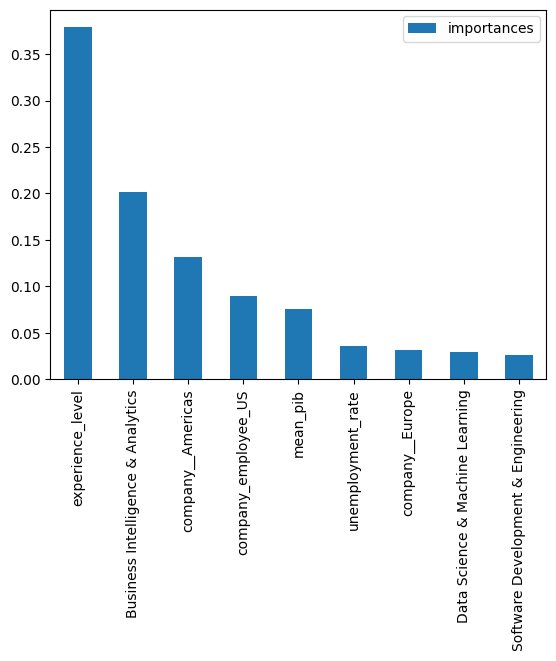

In [57]:
plt.figure(figsize=(4,13))
pd.DataFrame({'importances':rfr_rs_final.feature_importances_}, index=X0_train.columns).sort_values("importances",ascending=False).plot(kind='bar')
plt.plot();

In [60]:
X2_train.columns

Index(['experience_level', 'unemployment_rate', 'company_employee_US',
       'Business Intelligence & Analytics', 'Data Science & Machine Learning',
       'Software Development & Engineering'],
      dtype='object')

La feature_importance aquí ha cambiado así que vamos a probar con un nuevo conjunto de variables predictoras:

In [61]:
#Definimos el conjunto de variables predictoras y el target
X3_train = train_df[["experience_level", 'Business Intelligence & Analytics', "company__Americas", "company_employee_US", "mean_pib"]]
#X5_train = train_df[["experience_level", "USD_salary", "Data Analyst", "company__Americas", "mean_pib", "company__Europe", "unemployment_rate",  "Machine Learning Engineer"]]
#X6_train = train_df[["experience_level", "USD_salary", "Data Analyst", "company__Americas", "mean_pib", "company__Europe", "unemployment_rate"]]
#X7_train = train_df[["experience_level", "USD_salary", "Data Analyst", "company__Americas", "mean_pib", "company__Europe"]]
#X8_train = train_df[["experience_level", "USD_salary", "Data Analyst", "company__Americas", "mean_pib"]]
#X9_train = train_df[["experience_level", "USD_salary", "Data Analyst", "company__Americas"]]

X3_test = test_df[["experience_level", 'Business Intelligence & Analytics', "company__Americas", "company_employee_US", "mean_pib"]]
#X5_test = test_df[["experience_level", "USD_salary", "Data Analyst", "company__Americas", "mean_pib", "company__Europe", "unemployment_rate",  "Machine Learning Engineer"]]
#X6_test = test_df[["experience_level", "USD_salary", "Data Analyst", "company__Americas", "mean_pib", "company__Europe", "unemployment_rate"]]
#X7_test = test_df[["experience_level", "USD_salary", "Data Analyst", "company__Americas", "mean_pib", "company__Europe"]]
#X8_test = test_df[["experience_level", "USD_salary", "Data Analyst", "company__Americas", "mean_pib"]]
#X9_test = test_df[["experience_level", "USD_salary", "Data Analyst", "company__Americas"]]

In [62]:
#Entrenamos el modelo
rfr_rs_final.fit(X3_train, y_train)

RandomForestRegressor(max_depth=10, max_features=4, n_estimators=170)

In [63]:
#Cálculo del r cuadrado y del MAE para train y para test
print("R2 score train", rfr_rs_final.score(X3_train, y_train))
print("R2 score test", rfr_rs_final.score(X3_test, y_test))
print("MAE train", metrics.mean_absolute_error(y_train, rfr_rs_final.predict(X3_train)))
print("MAE test", metrics.mean_absolute_error(y_test, rfr_rs_final.predict(X3_test)))

R2 score train 0.2542843860011199
R2 score test 0.2712140407681174
MAE train 44314.538894015066
MAE test 43607.99667004412


Ha empeorado un poco con respecto a lo anterior, así que lo reentrenamos y lo almacenamos en formato pickle:

In [86]:
rfr_rs_final.fit(X0_train, y_train)
pickle.dump(rfr_rs_final, open("../models/trained_model_4.pkl", "wb"))
rfr_importado = pickle.load(open("../models/trained_model_4.pkl", "rb"))
rfr_importado.predict(X0_train)

array([ 99425.79987995, 119894.28492156, 182017.94257874, ...,
       137038.18269132, 182017.94257874, 168666.90816928])

## MODELO 5 (LightGBM)

In [65]:
#Definición del quinto modelo
lgbmr = lgb.LGBMRegressor()

params_lgbmr = {'num_leaves': np.arange(20,300,20),          
                'learning_rate': [0.01, 0.05, 0.1],
                'n_estimators': [100, 200, 500],
                'max_depth': np.arange(50,150,10),
              }

lgbmr_rs = RandomizedSearchCV(lgbmr, params_lgbmr, cv=3, scoring='neg_mean_absolute_error', verbose=3, n_jobs=-1, random_state=42, n_iter = 20)

In [66]:
lgbmr_rs.fit(X0_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 20718, number of used features: 9
[LightGBM] [Info] Start training from score 147173.937204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


RandomizedSearchCV(cv=3, estimator=LGBMRegressor(), n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140]),
                                        'n_estimators': [100, 200, 500],
                                        'num_leaves': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240, 260,
       280])},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=3)

In [67]:
print(lgbmr_rs.best_score_)
print(lgbmr_rs.best_params_)
print(lgbmr_rs.best_estimator_)

-44487.884795975195
{'num_leaves': 140, 'n_estimators': 500, 'max_depth': 60, 'learning_rate': 0.01}
LGBMRegressor(learning_rate=0.01, max_depth=60, n_estimators=500,
              num_leaves=140)


In [68]:
#Entrenamos el modelo que hemos obtenido como el mejor del randomized search previo
lgbmr_rs_final = lgbmr_rs.best_estimator_
lgbmr_rs_final.fit(X0_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 20718, number of used features: 9
[LightGBM] [Info] Start training from score 147173.937204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

LGBMRegressor(learning_rate=0.01, max_depth=60, n_estimators=500,
              num_leaves=140)

In [71]:
#Cálculo del r cuadrado y del MAE para train y para test
print("R2 score train", lgbmr_rs_final.score(X0_train, y_train))
print("R2 score test", lgbmr_rs_final.score(X0_test, y_test))
print("MAE train", metrics.mean_absolute_error(y_train, lgbmr_rs_final.predict(X0_train)))
print("MAE test", metrics.mean_absolute_error(y_test, lgbmr_rs_final.predict(X0_test)))

R2 score train 0.2624001108998477
R2 score test 0.28117630744808897
MAE train 44164.752096322896
MAE test 43313.33353982669


El $R^{2}$ ha mejorado pero el MAE ha emperado, ambas cosas ligeramente.

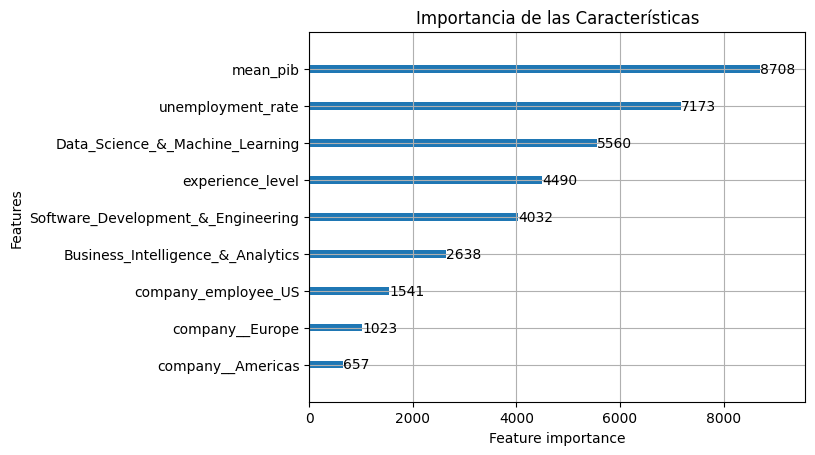

In [72]:
lgb.plot_importance(lgbmr_rs_final, max_num_features=11)  # Muestra las 10 características más importantes
plt.title("Importancia de las Características")
plt.show()

In [75]:
X4_train = train_df[["mean_pib", "unemployment_rate", "Data Science & Machine Learning", "experience_level", "Software Development & Engineering" ,'Business Intelligence & Analytics']]
X4_test = test_df[["mean_pib", "unemployment_rate", "Data Science & Machine Learning", "experience_level", "Software Development & Engineering" ,'Business Intelligence & Analytics']]

In [76]:
#Entrenamos el modelo con las variables predictoras más importantes para este modelo
lgbmr_rs_final.fit(X4_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 20718, number of used features: 6
[LightGBM] [Info] Start training from score 147173.937204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

LGBMRegressor(learning_rate=0.01, max_depth=60, n_estimators=500,
              num_leaves=140)

In [77]:
#Cálculo del r cuadrado y del MAE para train y para test
print("R2 score train", lgbmr_rs_final.score(X4_train, y_train))
print("R2 score test", lgbmr_rs_final.score(X4_test, y_test))
print("MAE train", metrics.mean_absolute_error(y_train, lgbmr_rs_final.predict(X4_train)))
print("MAE test", metrics.mean_absolute_error(y_test, lgbmr_rs_final.predict(X4_test)))

R2 score train 0.2609951837928214
R2 score test 0.2790285962773589
MAE train 44195.414349519495
MAE test 43363.141430673684


Como el resultado ha sido mejor para el modelo entrenado con el conjunto de variables predictoras X0, lo volvemos a entrenar y lo almacenamos en formato pickle:

In [94]:
lgbmr_rs_final.fit(X0_train, y_train)
pickle.dump(lgbmr_rs_final, open("../models/trained_model_5.pkl", "wb"))
lgbmr_rs_final_importado = pickle.load(open("../models/trained_model_5.pkl", "rb"))
lgbmr_rs_final_importado.predict(X0_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 20718, number of used features: 9
[LightGBM] [Info] Start training from score 147173.937204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

array([101887.87450855, 120085.69032251, 181786.17990105, ...,
       137165.03304625, 181786.17990105, 168612.07803854])

# RESUMEN - RESULTADOS DE MODELOS SUPERVISADOS

In [95]:
summary = {"Modelo":["Decision Tree Regressor", "SVR", "XGBoost", "Random Forest Regressor", "LightGBM"],
           "R2":[
               dtr_importado.score(X0_test, y_test), 
               svr_importado.score(X0_test_stand_scaler, y_test), 
               xgbr_importado.score(X0_test_stand_scaler, y_test), 
               rfr_importado.score(X0_test, y_test), 
               lgbmr_rs_final_importado.score(X0_test, y_test)],
           "MAE":[
               metrics.mean_absolute_error(y_test, dtr_importado.predict(X0_test)),
               metrics.mean_absolute_error(y_test, svr_importado.predict(X0_test_stand_scaler)),
               metrics.mean_absolute_error(y_test, xgbr_importado.predict(X0_test_stand_scaler)),
               metrics.mean_absolute_error(y_test, rfr_importado.predict(X0_test)),
               metrics.mean_absolute_error(y_test, lgbmr_rs_final_importado.predict(X0_test))]
}

results = pd.DataFrame(summary)
results

,Modelo,R2,MAE
0,Decision Tree Regressor,0.264576,42927.275775
1,SVR,0.100006,48510.454914
2,XGBoost,0.279748,43332.837077
3,Random Forest Regressor,0.279054,43355.165201
4,LightGBM,0.281176,43313.333540


In [98]:
results.sort_values(by=["MAE", "R2"], inplace=True)
results.reset_index(inplace=True, drop=True)
results

,Modelo,R2,MAE
0,Decision Tree Regressor,0.264576,42927.275775
1,LightGBM,0.281176,43313.333540
2,XGBoost,0.279748,43332.837077
3,Random Forest Regressor,0.279054,43355.165201
4,SVR,0.100006,48510.454914


# MODELO NO SUPERVISADO (FALTA POR REVISAR Y TERMINAR)

La idea es usar un PCA para simplificar los datos y mejorar el rendimiento del modelo eliminando las variables redundantes, para posteriormente aplicar el modelo previamente definido de Decision Tree Regressor.

_______________________________________

***PENDIENTE REVISAR Y TERMINAR***

In [115]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

In [145]:
pd.set_option('display.max_columns', None)
train_df_numeric = train_df.select_dtypes(include="number")
train_df_numeric

,work_year,experience_level,salary_in_usd,remote_ratio,company_size,mean_pib,unemployment_rate,contract,freelance,full_time,part_time,company_employee_US,company__Africa,company__Americas,company__Asia,company__Europe,company__Oceania,Business Intelligence & Analytics,Data Engineering & Infrastructure,Data Science & Machine Learning,Management & Leadership,Software Development & Engineering,Specialized Roles
0,2022,2,110820,0,2,1.905583e+12,4.293750,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
1,2024,1,215000,0,2,1.111938e+13,5.175000,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0
2,2024,3,165100,100,2,1.111938e+13,5.175000,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0
3,2024,2,136300,100,2,1.111938e+13,5.175000,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0
4,2024,3,145620,0,2,1.520535e+11,4.341667,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20713,2024,2,179000,0,2,1.111938e+13,5.175000,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1
20714,2024,3,198000,0,2,1.111938e+13,5.175000,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0
20715,2024,3,60000,0,2,1.111938e+13,5.175000,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0
20716,2024,3,282200,0,2,1.111938e+13,5.175000,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0


In [146]:
print('----------------------------------')
print('Media de cada variable numérica')
print('----------------------------------')
train_df_numeric.mean(axis=0)

----------------------------------
Media de cada variable numérica
----------------------------------


work_year                             2.023731e+03
experience_level                      2.477652e+00
salary_in_usd                         1.471739e+05
remote_ratio                          2.662419e+01
company_size                          2.026402e+00
mean_pib                              9.642721e+12
unemployment_rate                     5.336793e+00
contract                              3.668308e-03
freelance                             4.826721e-04
full_time                             9.925186e-01
part_time                             3.330437e-03
company_employee_US                   8.492615e-01
company__Africa                       2.268559e-03
company__Americas                     9.093059e-01
company__Asia                         4.006178e-03
company__Europe                       7.795154e-02
company__Oceania                      6.467806e-03
Business Intelligence & Analytics     2.314413e-01
Data Engineering & Infrastructure     1.407472e-01
Data Science & Machine Learning

In [147]:
print('----------------------------------')
print('Varianza de cada variable numérica')
print('----------------------------------')
train_df_numeric.var(axis=0)

----------------------------------
Varianza de cada variable numérica
----------------------------------


work_year                             3.438077e-01
experience_level                      5.385506e-01
salary_in_usd                         4.163667e+09
remote_ratio                          1.932669e+03
company_size                          3.806333e-02
mean_pib                              1.256680e+25
unemployment_rate                     1.702895e+00
contract                              3.655028e-03
freelance                             4.824624e-04
full_time                             7.425804e-03
part_time                             3.319506e-03
company_employee_US                   1.280226e-01
company__Africa                       2.263522e-03
company__Americas                     8.247265e-02
company__Asia                         3.990321e-03
company__Europe                       7.187857e-02
company__Oceania                      6.426283e-03
Business Intelligence & Analytics     1.778848e-01
Data Engineering & Infrastructure     1.209432e-01
Data Science & Machine Learning

Estandarizamos todas las variables numéricas (excepto la que es la variable target)

In [148]:
pca_pipe = make_pipeline(StandardScaler(), PCA(n_components=22))
pca_pipe.fit(train_df_numeric.drop(columns="salary_in_usd"))
modelo_pca = pca_pipe['pca']

In [149]:
modelo_pca

PCA(n_components=22)

In [153]:
modelo_pca.components_

array([[-9.64949006e-02, -6.71653657e-02,  2.87816397e-02,
         1.38706851e-02, -4.91980182e-01,  1.59356265e-01,
         2.76086747e-02,  3.63699839e-02, -3.66815107e-02,
         1.20273776e-02, -4.94279055e-01,  1.05161745e-01,
        -4.83681012e-01,  1.01821824e-01,  4.39722934e-01,
         1.19480537e-01,  2.71070955e-02,  2.74175022e-02,
         3.39236161e-02, -2.00895593e-02, -5.49217889e-02,
        -2.77071393e-02],
       [ 1.40226379e-02, -1.19846632e-01,  1.07365429e-02,
        -1.58162167e-02,  3.45512905e-02, -3.31404310e-02,
         4.85315878e-01,  1.70595228e-01, -6.98548622e-01,
         4.70506748e-01,  2.23306392e-02, -1.56161246e-03,
         2.60794998e-02, -6.71897297e-03, -3.08288793e-02,
         1.58983905e-02,  6.77466719e-02, -2.71341673e-02,
        -2.82915237e-02, -1.45070817e-02, -3.94669784e-03,
        -4.44492085e-03],
       [ 3.59017233e-01, -6.25848679e-02, -1.79595255e-01,
        -1.25589783e-01, -5.86794348e-02,  5.50376891e-01,
    

In [150]:
# Se convierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data = modelo_pca.components_,
    columns = train_df_numeric.drop(columns="salary_in_usd").columns,
    index = [f"PC{i}" for i in range(1, 23)]
)

,work_year,experience_level,remote_ratio,company_size,mean_pib,unemployment_rate,contract,freelance,full_time,part_time,company_employee_US,company__Africa,company__Americas,company__Asia,company__Europe,company__Oceania,Business Intelligence & Analytics,Data Engineering & Infrastructure,Data Science & Machine Learning,Management & Leadership,Software Development & Engineering,Specialized Roles
PC1,-9.649490e-02,-6.716537e-02,2.878164e-02,1.387069e-02,-4.919802e-01,1.593563e-01,0.027609,0.036370,-0.036682,0.012027,-4.942791e-01,0.105162,-0.483681,0.101822,0.439723,0.119481,0.027107,0.027418,0.033924,-0.020090,-0.054922,-0.027707
PC2,1.402264e-02,-1.198466e-01,1.073654e-02,-1.581622e-02,3.455129e-02,-3.314043e-02,0.485316,0.170595,-0.698549,0.470507,2.233064e-02,-0.001562,0.026079,-0.006719,-0.030829,0.015898,0.067747,-0.027134,-0.028292,-0.014507,-0.003947,-0.004445
PC3,3.590172e-01,-6.258487e-02,-1.795953e-01,-1.255898e-01,-5.867943e-02,5.503769e-01,0.015051,-0.044739,0.003557,-0.004057,-3.407279e-02,0.554467,0.083176,-0.018519,-0.174826,-0.027759,-0.011381,-0.136467,-0.230764,0.092477,0.283465,0.049479
PC4,-3.888395e-01,2.853871e-01,2.867816e-01,1.026508e-01,2.508370e-02,3.620752e-01,0.057965,0.060018,-0.055558,-0.000609,3.011974e-02,0.342536,0.108003,0.043701,-0.156909,-0.099873,-0.277476,0.179291,0.432050,-0.088829,-0.248210,-0.032994
PC5,-1.864205e-01,-3.538307e-01,1.769188e-01,1.026051e-01,4.058221e-02,1.617645e-01,-0.084045,-0.045023,0.070617,-0.000265,4.369705e-02,0.131432,0.071666,0.081223,-0.101137,-0.060501,0.705258,-0.053201,-0.160867,-0.139145,-0.405706,-0.038326
PC6,-1.081554e-01,1.493942e-01,1.590895e-01,2.731041e-02,-1.298258e-03,3.082589e-02,0.029305,0.019026,-0.018521,-0.010302,-3.174498e-03,-0.009279,0.006311,-0.007070,0.001399,-0.016208,-0.055442,0.719082,-0.638358,0.033152,0.038244,0.081492
PC7,-5.823125e-02,4.049475e-02,2.045203e-01,-1.057112e-01,-2.902075e-03,6.127506e-03,0.057598,0.102716,0.007951,-0.111490,-5.743793e-03,-0.035856,0.022570,0.078115,-0.019639,-0.055448,0.172257,0.051586,0.040508,-0.319386,0.508330,-0.713994
PC8,-1.333166e-01,-9.847903e-02,-7.702848e-03,3.348974e-01,7.643097e-03,-5.653107e-03,-0.017024,-0.023028,0.008036,0.014624,7.918185e-03,0.006464,-0.011637,0.090283,-0.022318,0.041352,-0.079847,-0.097858,-0.050660,-0.696679,0.340723,0.478073
PC9,-1.091771e-01,1.964802e-02,1.996201e-01,4.659174e-01,-1.330917e-02,1.233899e-02,-0.099161,0.046871,-0.011261,0.103026,-1.188940e-02,-0.080176,0.002245,0.566371,-0.058023,-0.212705,-0.076870,-0.255299,-0.160848,0.438390,0.203821,-0.031928
PC10,-2.584068e-03,1.004806e-01,1.021967e-01,-2.518689e-01,-1.659538e-02,-1.139733e-02,0.099311,0.589766,0.005213,-0.336846,-1.561096e-02,-0.042191,0.013995,0.306259,-0.227042,0.492894,0.056944,-0.110876,-0.059167,0.020638,-0.052069,0.178185


In [151]:
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('Porcentaje de varianza explicada acumulada:\n', prop_varianza_acum)

Porcentaje de varianza explicada acumulada:
 [0.16292887 0.25426083 0.32465079 0.39390398 0.45699003 0.51308183
 0.56578493 0.61678887 0.66541952 0.71272297 0.75920663 0.80506723
 0.84850218 0.89116736 0.92754048 0.95867672 0.98573572 0.99954581
 1.         1.         1.         1.        ]


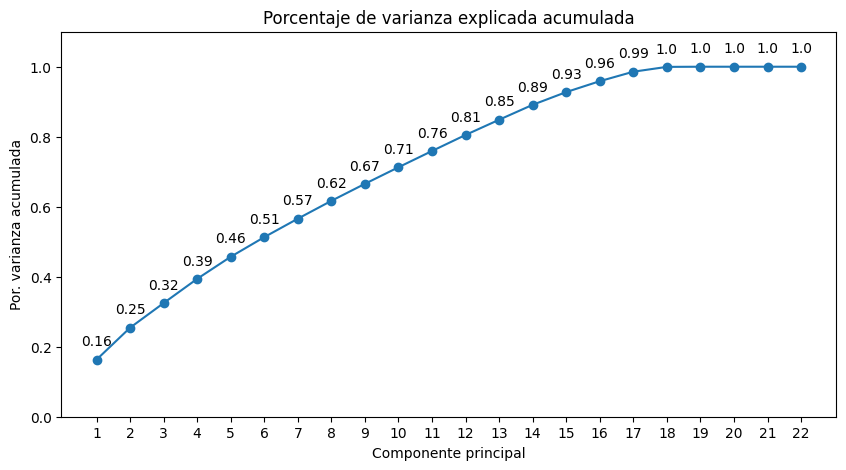

In [152]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.plot(
    np.arange(1,23),
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(1,23), prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(1,23))
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

En el gráfico anterior podemos ver que, empleando las 13 primeras componenentes se puede explicar el 85% de la varianza observada.

In [154]:
pca_pipe = make_pipeline(StandardScaler(), PCA(n_components=13))
modelo_pca = pca_pipe['pca']
proyecciones = pca_pipe.fit_transform(X=train_df_numeric.drop(columns="salary_in_usd"))
proyecciones = pd.DataFrame(
    proyecciones,
    columns = [f"PC{i}" for i in range(1, 14)],
    index   = train_df_numeric.index
)
proyecciones.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,5.520589,-0.447698,-2.533590,0.446011,-0.624253,-1.335154,-0.035202,0.212187,-0.403804,-1.016154,0.374915,0.027195,0.566210
1,-0.812387,0.154495,1.097546,-1.545440,-0.475062,-0.308108,1.043850,0.957209,0.252817,-0.356433,-0.292893,0.528201,0.433842
2,-0.929968,-0.147710,0.518445,-0.115298,-1.036941,0.460935,1.619444,0.671294,0.760450,0.149886,0.786093,-0.721659,-1.193414
3,-0.620131,-0.039801,-0.651835,1.127292,0.105964,-1.316858,0.363792,-0.179177,-0.157366,0.008643,0.283264,-0.045082,-0.267391
4,5.169331,-0.560186,-0.115806,-0.536138,-0.227371,-0.018417,-0.122696,-1.285443,10.407128,5.026939,-1.912651,2.406579,5.749538


In [156]:
reconstruccion = pca_pipe.inverse_transform(proyecciones)
reconstruccion = pd.DataFrame(
    reconstruccion,
    columns = train_df_numeric.drop(columns="salary_in_usd").columns,
    index = train_df_numeric.drop(columns="salary_in_usd").index
)

print('------------------')
print('Valores originales')
print('------------------')
display(train_df_numeric.drop(columns="salary_in_usd").head())

print('---------------------')
print('Valores reconstruidos')
print('---------------------')
display(reconstruccion.head())

------------------
Valores originales
------------------


,work_year,experience_level,remote_ratio,company_size,mean_pib,unemployment_rate,contract,freelance,full_time,part_time,company_employee_US,company__Africa,company__Americas,company__Asia,company__Europe,company__Oceania,Business Intelligence & Analytics,Data Engineering & Infrastructure,Data Science & Machine Learning,Management & Leadership,Software Development & Engineering,Specialized Roles
0,2022,2,0,2,1.905583e+12,4.293750,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
1,2024,1,0,2,1.111938e+13,5.175000,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0
2,2024,3,100,2,1.111938e+13,5.175000,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0
3,2024,2,100,2,1.111938e+13,5.175000,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0
4,2024,3,0,2,1.520535e+11,4.341667,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0


---------------------
Valores reconstruidos
---------------------


,work_year,experience_level,remote_ratio,company_size,mean_pib,unemployment_rate,contract,freelance,full_time,part_time,company_employee_US,company__Africa,company__Americas,company__Asia,company__Europe,company__Oceania,Business Intelligence & Analytics,Data Engineering & Infrastructure,Data Science & Machine Learning,Management & Leadership,Software Development & Engineering,Specialized Roles
0,2022.974603,2.309244,30.284658,2.086041,6.096864e+11,4.702871,-0.000284,-0.002546,0.997198,0.005631,-0.090681,-0.029895,0.070045,0.019855,0.946921,-0.006925,0.053810,0.113054,1.144515,-0.125606,-0.189850,0.004077
1,2024.341048,1.969831,-17.596221,2.054631,1.076174e+13,5.117561,-0.004008,-0.001622,0.992742,0.012889,0.969437,-0.001395,0.992457,0.022199,-0.005757,-0.007505,0.249096,-0.006293,-0.001202,-0.101134,0.875699,-0.016167
2,2023.770353,3.231712,79.186064,2.009406,1.072163e+13,5.312347,-0.000492,0.002262,0.997760,0.000470,0.957662,-0.005866,1.039442,-0.009094,-0.018948,-0.005533,0.072870,-0.043491,-0.049717,0.010264,1.019608,-0.009535
3,2023.441567,2.710466,48.267669,2.002606,1.093335e+13,5.257174,-0.002473,0.003057,0.994059,0.005356,0.975588,0.000673,1.018566,-0.008601,-0.002630,-0.008007,0.211383,-0.112896,0.868707,0.013313,0.042300,-0.022806
4,2023.329016,1.258258,-27.457426,2.754356,6.424330e+11,6.008952,0.004252,0.101206,1.005485,-0.110943,-0.052730,-0.026466,0.172130,0.677377,0.219362,-0.042403,-0.257768,-0.107319,-0.126135,1.415258,0.279347,-0.203383


# RED NEURONAL
_______________________________________

***PENDIENTE DE HACER***